In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

from sklearn.preprocessing import LabelEncoder, StandardScaler


from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


In [2]:
data = pd.read_csv('world-happiness-report-2021.csv', sep=',')

In [3]:
data.head()

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.0,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.7,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.4,0.919,0.025,0.292,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.0,0.955,0.160,0.673,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.4,0.913,0.175,0.338,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798


Удалим 1й признак тк это фактически id, целевой признак - Ladder Score

В описании датасета сказано, что колонуи Explained_by не имеют отношения к результату, на их основе формируется LS in Dystopia. Также необходимо удалить upper и lowerwhisker, тк они отношения не имеют

In [4]:
data.drop(columns=['Explained by: Log GDP per capita','Explained by: Log GDP per capita','Explained by: Healthy life expectancy','Explained by: Freedom to make life choices','Explained by: Generosity','Explained by: Perceptions of corruption', 'Explained by: Social support'], inplace=True)

In [5]:
data.drop(columns=data.columns[0], inplace=True)
data.drop(columns=['upperwhisker', 'lowerwhisker'], inplace=True)

In [6]:
data.duplicated().sum()

0

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Regional indicator              149 non-null    object 
 1   Ladder score                    149 non-null    float64
 2   Standard error of ladder score  149 non-null    float64
 3   Logged GDP per capita           149 non-null    float64
 4   Social support                  149 non-null    float64
 5   Healthy life expectancy         149 non-null    float64
 6   Freedom to make life choices    149 non-null    float64
 7   Generosity                      149 non-null    float64
 8   Perceptions of corruption       149 non-null    float64
 9   Ladder score in Dystopia        149 non-null    float64
 10  Dystopia + residual             149 non-null    float64
dtypes: float64(10), object(1)
memory usage: 12.9+ KB


labels

In [8]:
le = LabelEncoder()
le.fit_transform(data['Regional indicator'])
data['Regional indicator'] = le.fit_transform(data['Regional indicator'])
for i in range(10):
    print(f'{i}: {le.inverse_transform([i]).tolist()[0]}')

0: Central and Eastern Europe
1: Commonwealth of Independent States
2: East Asia
3: Latin America and Caribbean
4: Middle East and North Africa
5: North America and ANZ
6: South Asia
7: Southeast Asia
8: Sub-Saharan Africa
9: Western Europe


In [9]:
col_num = data.dtypes[data.dtypes!=object].index.values.tolist()
col_num.remove("Ladder score")
se = StandardScaler()
data[col_num] = se.fit_transform(data[col_num])

In [10]:
data.head()

,Regional indicator,Ladder score,Standard error of ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Dystopia + residual
0,1.254062,7.842,-1.220020,1.162885,1.216171,1.039750,1.393550,-0.551886,-3.031228,0.0,1.535298
1,1.254062,7.620,-1.083204,1.299717,1.216171,1.143618,1.366990,0.300594,-3.070416,0.0,0.816798
2,1.254062,7.571,-1.037599,1.459064,1.111370,1.395869,1.127948,0.267294,-2.437802,0.0,0.762677
3,1.254062,7.554,0.011325,1.252086,1.469440,1.188133,1.446671,1.166393,-0.304829,0.0,1.001555
4,1.254062,7.464,-1.448047,1.298851,1.111370,1.099103,1.074828,1.266293,-2.180278,0.0,0.686161


In [11]:
cols = data.columns.tolist()
cols = cols[2:] + cols[:2]

In [12]:
data = data[cols]

In [13]:
data.head()

,Standard error of ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Dystopia + residual,Regional indicator,Ladder score
0,-1.220020,1.162885,1.216171,1.039750,1.393550,-0.551886,-3.031228,0.0,1.535298,1.254062,7.842
1,-1.083204,1.299717,1.216171,1.143618,1.366990,0.300594,-3.070416,0.0,0.816798,1.254062,7.620
2,-1.037599,1.459064,1.111370,1.395869,1.127948,0.267294,-2.437802,0.0,0.762677,1.254062,7.571
3,0.011325,1.252086,1.469440,1.188133,1.446671,1.166393,-0.304829,0.0,1.001555,1.254062,7.554
4,-1.448047,1.298851,1.111370,1.099103,1.074828,1.266293,-2.180278,0.0,0.686161,1.254062,7.464


In [14]:
data.drop(columns=['Ladder score in Dystopia'], inplace=True)

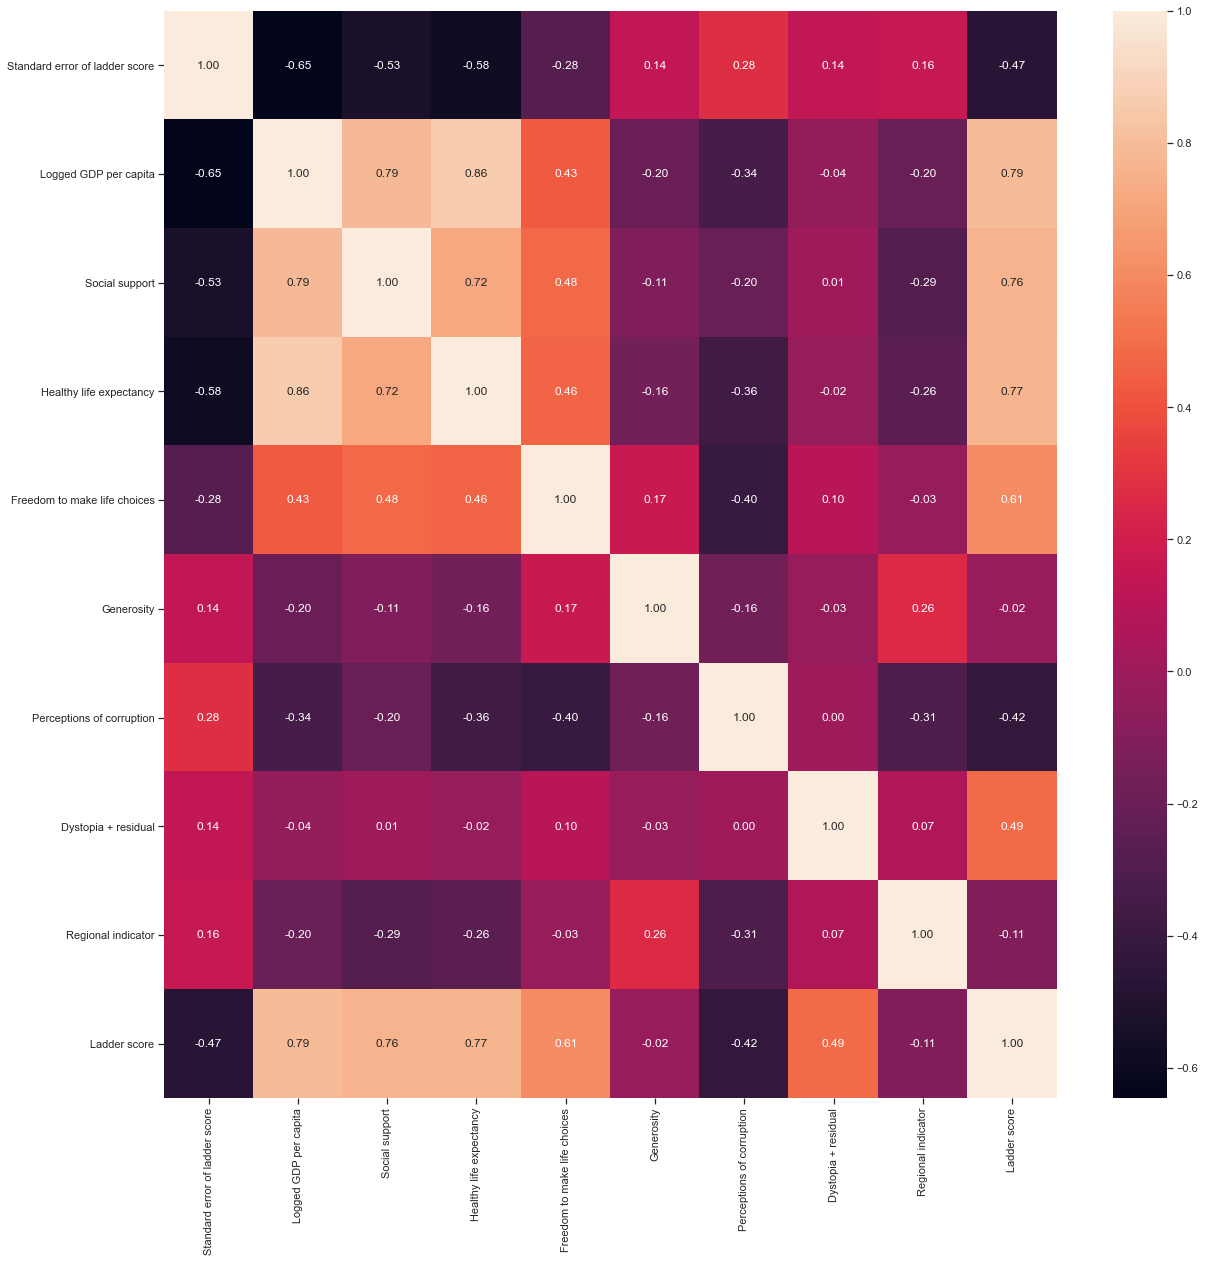

In [15]:
plt.figure(figsize=(20,20))
g = sns.heatmap(data.corr(), annot=True, fmt='.2f')

In [16]:
TEST_SIZE = 0.3
RANDOM_STATE = 1
data_X = data.drop(columns='Ladder score')
data_Y = data['Ladder score']
data_X_train, data_X_test, data_Y_train, data_Y_test = train_test_split \
(data_X, data_Y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [17]:
def print_metrics(X_train, Y_train, X_test, Y_test, clf):
    with suppress_stdout():
        clf.fit(X_train, Y_train)
    target = clf.predict(X_test)
    ret = (mean_squared_error(Y_test, target), mean_absolute_error(Y_test, target), r2_score(Y_test, target))
    print(f'MSE: {ret[0]}, MeanAE: {ret[1]}, R2: {ret[2]}' )
    return ret

# Бустинг с помощью CatRegressor

In [18]:
gb = CatBoostRegressor(random_state=RANDOM_STATE, eval_metric = 'MAE')

In [19]:
boost_metric = print_metrics(data_X_train, data_Y_train, data_X_test, data_Y_test, CatBoostRegressor(random_state=RANDOM_STATE, eval_metric = 'MAE'))

MSE: 0.043627848151670374, MeanAE: 0.13530275955642032, R2: 0.956606146208312


In [20]:

def plot_learning_curve(data_X, data_y, clf, score, name):
    with suppress_stdout():
        train_sizes, train_scores, test_scores = learning_curve(estimator=clf, scoring=score, X=data_X, y=data_y,
                                                            train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=f'тренировочная {name}-мера')
    plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
             label=f'проверочная {name}-мера')
    plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
    plt.grid()
    plt.legend(loc='lower right')
    plt.xlabel('Число тренировочных образцов')
    plt.ylabel(f'{name}-мера')
    plt.show()

    

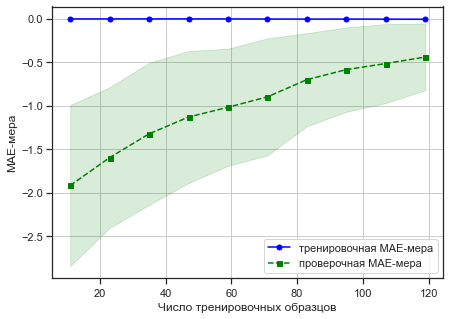

In [21]:
plot_learning_curve(data_X, data_Y, gb, score = 'neg_mean_absolute_error', name='MAE')

В итоге получаем очень хорошую модель 

# Случайный лес

In [22]:
rf = RandomForestRegressor()

In [23]:
params = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [0.02, 0.04, 0.05, 0.06],
    'max_features': [0.7, 0.8, 0.9, 0.99]
}

In [24]:
grid = GridSearchCV(estimator = RandomForestRegressor(random_state=1), param_grid=params, cv=10, scoring='neg_mean_squared_error')

In [25]:
grid.fit(data_X_train, data_Y_train)
print(f'Best Param = {grid.best_params_}, score = {grid.best_score_}')

Best Param = {'max_depth': 8, 'max_features': 0.9, 'min_samples_leaf': 0.02}, score = -0.1286631281344961


In [26]:
rf = RandomForestRegressor(random_state=1, max_depth=grid.best_params_.get('max_depth'),\
                          max_features=grid.best_params_.get('max_features'),\
                          min_samples_leaf=grid.best_params_.get('min_samples_leaf'))

In [27]:
def show_feature_importance(importance, col_names):
    data = pd.DataFrame({'feature_names':np.array(col_names),'feature_importance':np.array(importance)})
    data.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,7))
    sns.barplot(x=data['feature_importance'], y=data['feature_names'])
    plt.title('Feature importance using DecisionTreeClassifier')
    plt.xlabel('importance')
    plt.ylabel('name')

In [28]:
tree_metric = print_metrics(data_X_train, data_Y_train, data_X_test, data_Y_test, rf)

MSE: 0.08224406852351604, MeanAE: 0.2039995074111799, R2: 0.9181970407448028


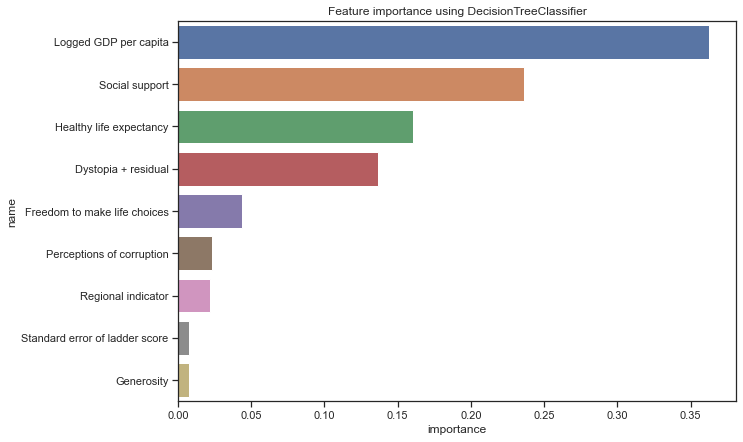

In [29]:
show_feature_importance(rf.feature_importances_, data_X_test.columns.tolist())

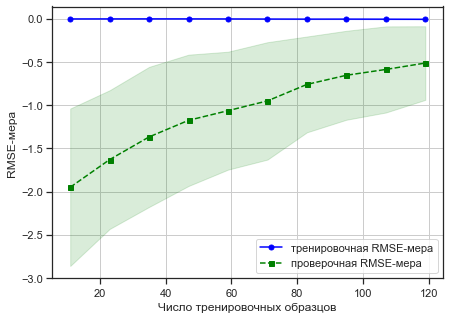

In [30]:
plot_learning_curve(data_X, data_Y, gb, score = 'neg_root_mean_squared_error', name='RMSE')

# Итог

In [31]:
labels=['GradBoost', 'RandomForest']
scores={'MSE': [boost_metric[0],tree_metric[0]], 'MAE': [boost_metric[1],tree_metric[1]], 'R2': [boost_metric[2],tree_metric[2]]}
pd.DataFrame(scores, index=labels)

,MSE,MAE,R2
GradBoost,0.043628,0.135303,0.956606
RandomForest,0.082244,0.204000,0.918197


CatBoostRegressor справился лучше чем RF по всем метрикам